## Load datasets

In [571]:
#!pip install pandas
import pandas as pd

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

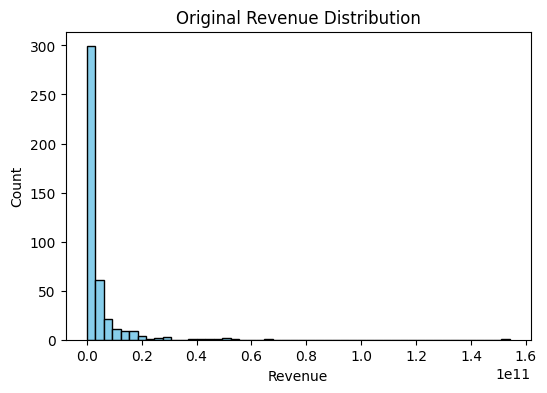

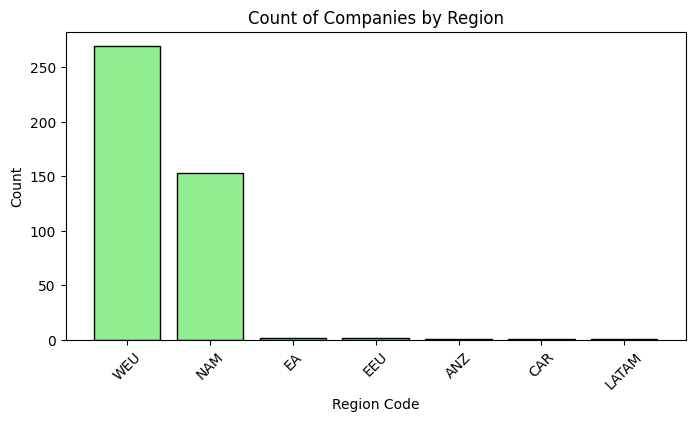

In [572]:

import matplotlib.pyplot as plt

# Histogram of revenue
plt.figure(figsize=(6,4))
plt.hist(train['revenue'], bins=50, color='skyblue', edgecolor='black')
plt.title('Original Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

# Count plot for region_code
region_counts = train['region_code'].value_counts()
plt.figure(figsize=(8,4))
plt.bar(region_counts.index, region_counts.values, color='lightgreen', edgecolor='black')
plt.title('Count of Companies by Region')
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## Create dummy variables for categorical colums
The main fact table has region and country data that could influence company behavior with respect to emissions due to different standards/regulations across the world.

We will take the region column (region_code) and create a new boolean column for each unique region in the dataset that can be used in a model.

In [573]:
#create true/false columns for every region value in the dataset
def one_hot_encode_region(df):
    df = pd.get_dummies(df, columns=["region_code"])
    return df

#apply to train dataset
train = one_hot_encode_region(train)
#also apply to test dataset so we can have it ready for inference later
test = one_hot_encode_region(test)

#print newly added columns
train.filter(regex='^region_code')

,region_code_ANZ,region_code_CAR,region_code_EA,region_code_EEU,region_code_LATAM,region_code_NAM,region_code_WEU
0,False,False,False,False,False,False,True
1,False,False,False,False,False,True,False
2,False,False,False,False,False,False,True
3,False,False,False,False,False,True,False
4,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...
424,False,False,False,False,False,True,False
425,False,False,False,False,False,True,False
426,False,False,False,False,False,False,True
427,False,False,False,False,False,True,False


## Build entity-level features from the sector distribution table
Since this table has a 1:many relationship with our train/test tables (i.e., a company might have more than one sector) so we will need to transform the data in this table so that there is one row per entity that we can then join back to the train/test table.

We will sum the revenue percentage up to the level 1 NACE code for each entity and turning the NACE codes into columns so we can have one row per entity.

In [574]:
#load sector distribution table
sect = pd.read_csv("../data/revenue_distribution_by_sector.csv")

#pivot by entity and nace level 1 while summing up the revenue percentage
level_1_sect = sect.pivot_table(
    values='revenue_pct',
    index='entity_id',
    columns='nace_level_1_code',
    aggfunc='sum',
    fill_value=0
).add_prefix('sect_').add_suffix('_pct').reset_index()

#join the sector features to the train and test data
train = train.merge(level_1_sect, on='entity_id')
test = test.merge(level_1_sect, on='entity_id')

#print newly added columns
train.filter(regex='^sect_')

,sect_A_pct,sect_B_pct,sect_C_pct,sect_D_pct,sect_E_pct,sect_F_pct,sect_G_pct,sect_H_pct,sect_I_pct,sect_J_pct,sect_K_pct,sect_L_pct,sect_M_pct,sect_N_pct,sect_O_pct,sect_P_pct,sect_Q_pct,sect_R_pct,sect_S_pct,sect_T_pct
0,0.0,0.0,1.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.862102,0.0,0.0,0.137898,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.0,0.0,1.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,0.0,0.0,0.0,0.0,0.0,0.0,0.19518,0.0,0.0,0.772506,0.0,0.0,0.032314,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426,0.0,0.0,1.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
427,0.0,0.0,1.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build environmental activity features
Similar to the sector distribution table, this table also has 1:many relationship. However, while a company can have multiple environmental activities listed, the company can also have NO environmental activities so it will be not be listed at all in this dataset. The absence of environmental activities potentially a predictive signal for emissions as well that we can incorporate.

We will sum the `env_score_adjustment` column to see the total impact of each company's environmental activities.

In [575]:
#load dataset
env = pd.read_csv("../data/environmental_activities.csv")

#pivot by entity and nace level 1 while summing up the revenue percentage
env_adjustment = env.groupby('entity_id')['env_score_adjustment'].sum().reset_index()

#when joining this new feature to the train/test data we have to
# be careful not to drop any records since we know not every
# entity partakes ina additional environmental activities
train = train.merge(env_adjustment, on='entity_id', how='left') #left join to not drop train records
test = test.merge(env_adjustment, on='entity_id', how='left') #left join to not drop test records

#we also need to replace nulls with 0 for the companies that dont have environmental activities
# meaning they are not receiving any additional benefit or penalty
train['env_score_adjustment'] = train['env_score_adjustment'].fillna(0)
test['env_score_adjustment'] = test['env_score_adjustment'].fillna(0)

#print our new column
train['env_score_adjustment']

0     -0.100000
1      0.004256
2      0.000000
3      0.000000
4     -0.300000
         ...   
424    0.000000
425    0.000000
426   -0.950000
427   -0.500000
428   -0.100000
Name: env_score_adjustment, Length: 429, dtype: float64

## Build features related to sustainable development goals
This table is similar to the environmental activities in that it is 1:many but not all companies have committed to these goals publicly.

Let's use a combination of the techniques we've applied previously to create features related to sustainable development goals.

In [576]:
#load dataset
sdg = pd.read_csv("../data/sustainable_development_goals.csv")

#create true/false columns for every SDG value in the dataset
# but first drop the column we dont need
sdg = sdg.drop(columns=['sdg_name'])
sdg = pd.get_dummies(sdg, columns=["sdg_id"])

sdg = sdg.groupby('entity_id').sum().reset_index()

#joining these features to the train/test data using left join
# to not drop any companies that don't have an SDG
train = train.merge(sdg, on='entity_id', how='left')
test = test.merge(sdg, on='entity_id', how='left')

#replace nulls with False for the companies that dont have SDGs
sdg_cols_train = train.filter(like='sdg').columns
train[sdg_cols_train] = train[sdg_cols_train].fillna(0)
sdg_cols_test = test.filter(like='sdg').columns
test[sdg_cols_test] = test[sdg_cols_test].fillna(0)

#print newly added columns
train.filter(regex='^sdg_')

,sdg_id_2,sdg_id_3,sdg_id_4,sdg_id_5,sdg_id_6,sdg_id_7,sdg_id_8,sdg_id_9,sdg_id_11,sdg_id_12,sdg_id_13,sdg_id_16
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


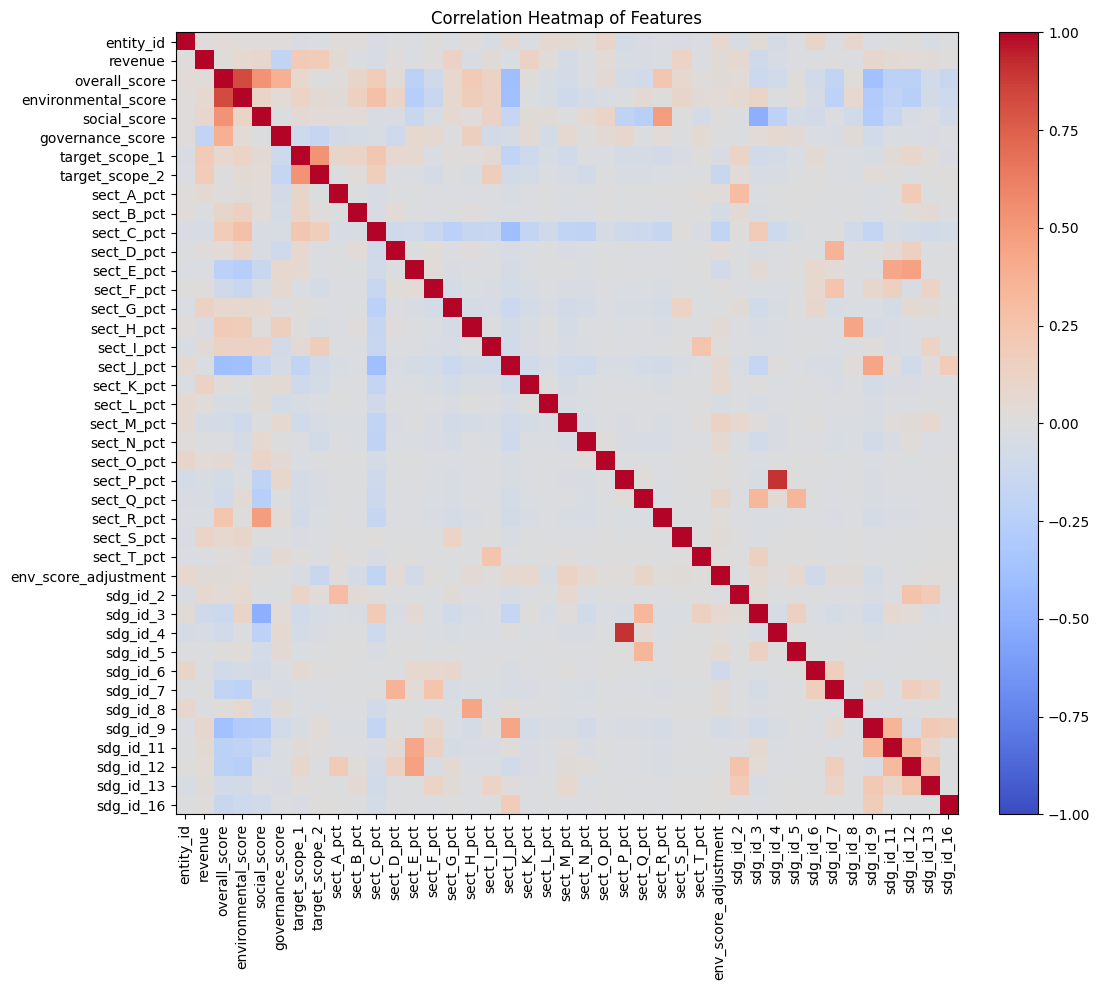

In [577]:


import matplotlib.pyplot as plt
import numpy as np

# Select numeric columns
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
corr_matrix = train[numeric_cols].corr().values  # get correlation values as numpy array

plt.figure(figsize=(12,10))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)  # show heatmap

# Add colorbar
plt.colorbar(im, fraction=0.046, pad=0.04)

# Set ticks and labels
plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=90)
plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)

plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()



## Feature Selection
We have now put together a dataset of nearly 50 columns that we can use as features for our model training. It is unlikely that all of these columns will provide an equal amout of signal to help us predict emissions and in many cases training with too many features (especially features  with little predictive power) actually hurts the performance of several types of statistical/machine learning models.

We will use a very basic form of feature selection to exclude columns that have values that are too similar or clustered together and will likely not give us any predictive power. Another very common form of feature selection involves calculating the correlation between the target variable you are trying to predict and each potential feature column.

In [578]:
#!pip install scikit-learn
from sklearn.feature_selection import VarianceThreshold

# Exclude non-feature columns from our feature selection process
cols_to_exclude = ['entity_id', 'region_name', 'country_name', 'country_code', 'target_scope_1', 'target_scope_2']
full_feature_set = train.drop(columns=cols_to_exclude)

# Identify features with variance above threshold (default = 0)
feature_selector = VarianceThreshold(threshold=0.05).fit(full_feature_set)

#print the selected features
selected_features = feature_selector.get_feature_names_out().tolist()
selected_features

['revenue',
 'overall_score',
 'environmental_score',
 'social_score',
 'governance_score',
 'region_code_NAM',
 'region_code_WEU',
 'sect_C_pct',
 'sect_G_pct',
 'sect_J_pct',
 'env_score_adjustment',
 'sdg_id_3',
 'sdg_id_9']

In [579]:
import numpy as np

# Handle skewed revenue
train['revenue_log'] = np.log1p(train['revenue'])
test['revenue_log'] = np.log1p(test['revenue'])

# Add the new feature to the selected features list
selected_features.append('revenue_log')

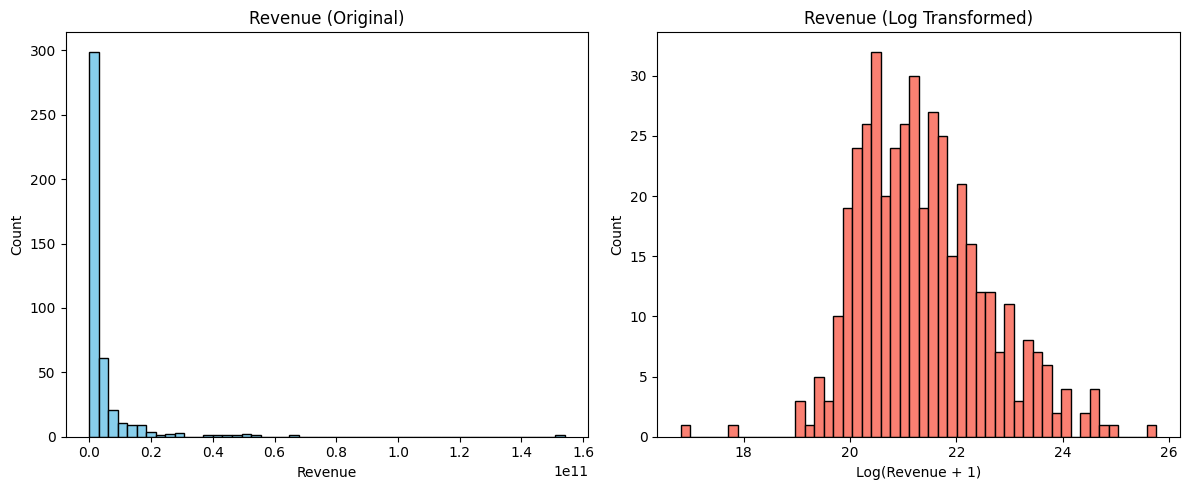

In [580]:
import numpy as np
import matplotlib.pyplot as plt
# If revenue_log is missing, create it
if 'revenue_log' not in train.columns:
    train['revenue_log'] = np.log1p(train['revenue'])

plt.figure(figsize=(12,5))

# # Original revenue
plt.subplot(1,2,1)
plt.hist(train['revenue'], bins=50, color='skyblue', edgecolor='black')
plt.title('Revenue (Original)')
plt.xlabel('Revenue')
plt.ylabel('Count')

# Log-transformed revenue
plt.subplot(1,2,2)
plt.hist(train['revenue_log'], bins=50, color='salmon', edgecolor='black')
plt.title('Revenue (Log Transformed)')
plt.xlabel('Log(Revenue + 1)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


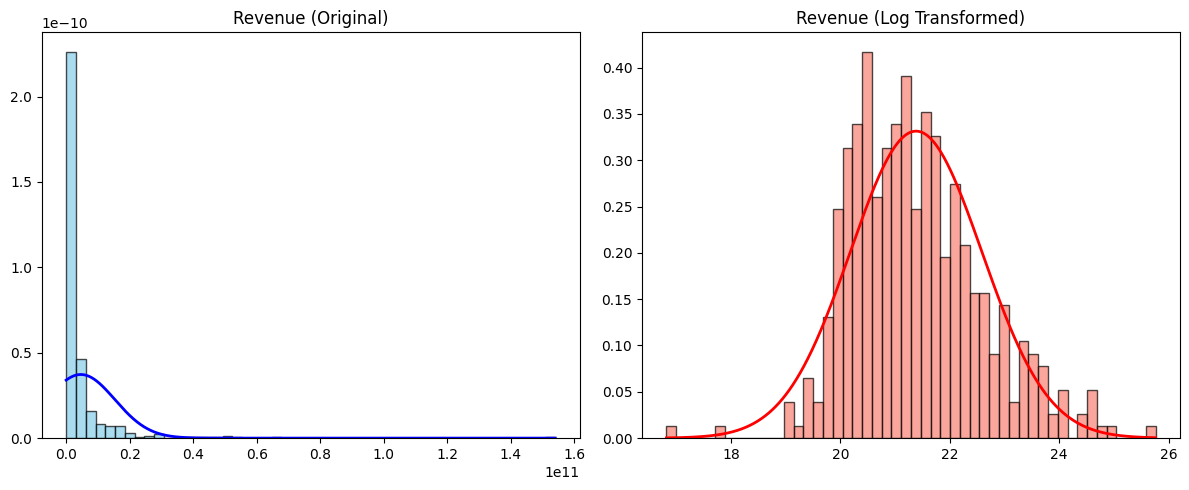

In [581]:

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,5))

# Original Revenue
plt.subplot(1,2,1)
plt.hist(train['revenue'], bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)

# Overlay KDE using numpy
revenue_values = np.linspace(train['revenue'].min(), train['revenue'].max(), 1000)
revenue_kde = (1/(train['revenue'].std() * np.sqrt(2*np.pi)) * 
               np.exp(-0.5*((revenue_values - train['revenue'].mean())/train['revenue'].std())**2))
plt.plot(revenue_values, revenue_kde, color='blue', lw=2)

plt.title('Revenue (Original)')

# Log-Transformed Revenue
plt.subplot(1,2,2)
plt.hist(train['revenue_log'], bins=50, color='salmon', edgecolor='black', alpha=0.7, density=True)

# Overlay KDE using numpy
revenue_log_values = np.linspace(train['revenue_log'].min(), train['revenue_log'].max(), 1000)
revenue_log_kde = (1/(train['revenue_log'].std() * np.sqrt(2*np.pi)) * 
                   np.exp(-0.5*((revenue_log_values - train['revenue_log'].mean())/train['revenue_log'].std())**2))
plt.plot(revenue_log_values, revenue_log_kde, color='red', lw=2)

plt.title('Revenue (Log Transformed)')

plt.tight_layout()
plt.show()

In [582]:

#create new dataframes with the selected features and entity_id and target variables
final_train = train[selected_features + ['entity_id','target_scope_1', 'target_scope_2']]
final_test = test[selected_features + ['entity_id']]

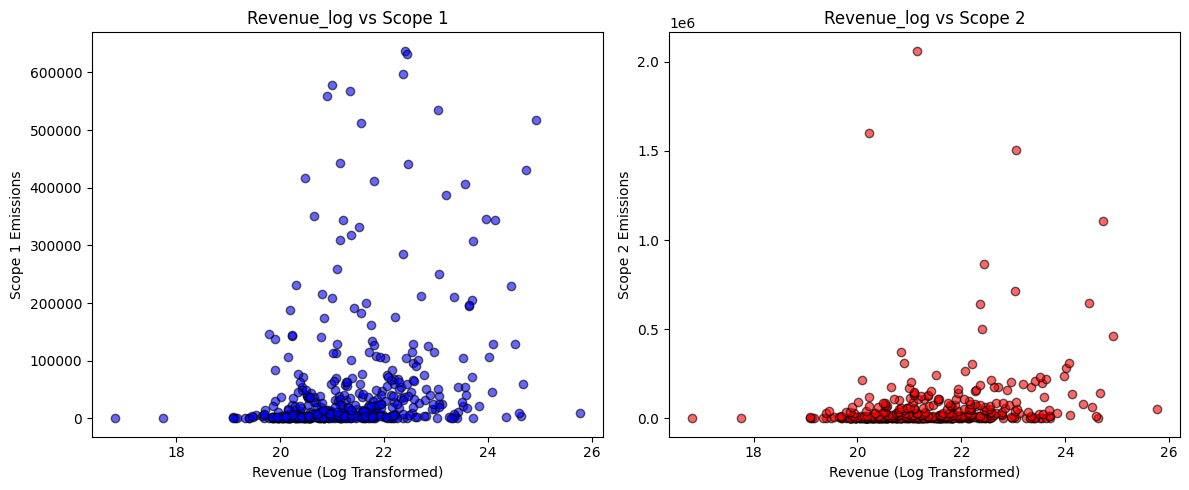

In [583]:

import matplotlib.pyplot as plt


plt.figure(figsize=(12,5))

# Scatter: Revenue_log vs Scope 1
plt.subplot(1,2,1)
plt.scatter(final_train['revenue_log'], final_train['target_scope_1'], alpha=0.6, color='blue', edgecolor='k')
plt.xlabel('Revenue (Log Transformed)')
plt.ylabel('Scope 1 Emissions')
plt.title('Revenue_log vs Scope 1')

# Scatter: Revenue_log vs Scope 2
plt.subplot(1,2,2)
plt.scatter(final_train['revenue_log'], final_train['target_scope_2'], alpha=0.6, color='red', edgecolor='k')
plt.xlabel('Revenue (Log Transformed)')
plt.ylabel('Scope 2 Emissions')
plt.title('Revenue_log vs Scope 2')

plt.tight_layout()
plt.show()

In [584]:
final_train.to_pickle(path='final_train.pkl')
final_test.to_pickle(path='final_test.pkl')

print(final_train)
print(final_test)

          revenue  overall_score  environmental_score  social_score  \
0    3.528060e+08          2.988                3.900         1.750   
1    1.513700e+09          2.770                3.004         2.942   
2    1.560000e+09          2.501                2.979         2.560   
3    1.238511e+10          3.207                3.776         3.000   
4    2.980000e+09          1.998                2.138         1.785   
..            ...            ...                  ...           ...   
424  5.510000e+09          2.994                3.875         2.560   
425  5.510000e+10          2.425                2.629         2.354   
426  1.020000e+10          2.358                2.354         3.000   
427  6.090000e+08          2.958                3.500         3.063   
428  1.540000e+09          3.102                3.900         3.000   

     governance_score  region_code_NAM  region_code_WEU  sect_C_pct  \
0               2.833            False             True         1.0   
1    

In [585]:
import pandas as pd

# Load cleaned feature-engineered data
train = pd.read_pickle('final_train.pkl')
test = pd.read_pickle('final_test.pkl')

# Separate features and targets
selected_features = [col for col in train.columns 
                     if col not in ['entity_id', 'target_scope_1', 'target_scope_2']]

x_train = train[selected_features]
y_scope1 = train['target_scope_1']
y_scope2 = train['target_scope_2']

x_test = test[selected_features]
entity_id_test = test['entity_id']

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def validate_model(x, y):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        pipeline,
        x,
        y,
        cv=kfold,
        scoring='neg_mean_squared_error'
    )
    
    rmse = np.sqrt(-scores)
    
    print("RMSE scores:", rmse)
    print("Mean RMSE:", rmse.mean())
    print("Std RMSE:", rmse.std())

print("Scope 1 results:")
validate_model(x_train, y_scope1)

print("\nScope 2 results:")
validate_model(x_train, y_scope2)



Scope 1 results:
RMSE scores: [133422.78132096  98572.95659937 106891.89022782  91938.02672004
  91389.65056992]
Mean RMSE: 104443.06108762347
Std RMSE: 15537.351681296392

Scope 2 results:
RMSE scores: [167419.49212112 185236.19964815  86912.76537692  80307.22373449
 274623.85227414]
Mean RMSE: 158899.906630964
Std RMSE: 71438.32804990513


In [586]:
# Train final Scope 1 model
s1_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
s1_pipeline.fit(x_train, y_scope1)

# Train final Scope 2 model
s2_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
s2_pipeline.fit(x_train, y_scope2)

# Predict
s1_predictions = s1_pipeline.predict(x_test)
s2_predictions = s2_pipeline.predict(x_test)


In [587]:
submission = pd.DataFrame({
    'entity_id': entity_id_test,
    's1_predictions': s1_predictions,
    's2_predictions': s2_predictions
})

submission.to_csv('submission.csv', index=False)

submission

,entity_id,s1_predictions,s2_predictions
0,1076,37056.263192,40174.828246
1,2067,58002.419505,35322.087395
2,910,76265.572092,106384.876228
3,4082,113703.913695,102490.485434
4,4102,26894.692547,12794.286425
5,1535,31112.238727,32314.365748
6,4213,40518.885760,13657.458861
7,107,44412.657023,52360.028431
8,2301,30945.341291,54399.125330
9,1463,45546.407009,34748.201501


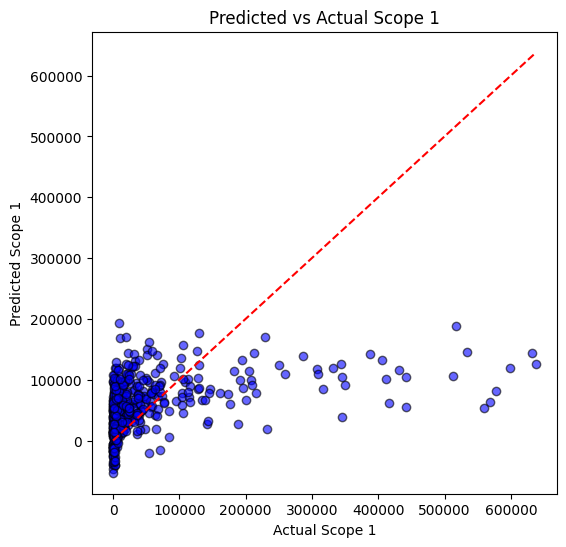

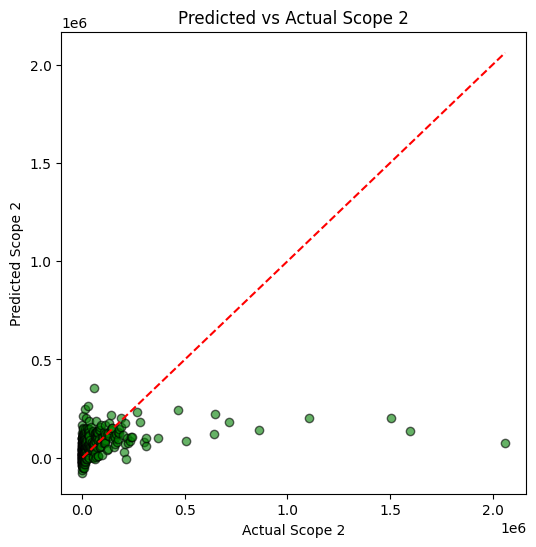

In [588]:
import matplotlib.pyplot as plt

# Scope 1
plt.figure(figsize=(6,6))
plt.scatter(y_scope1, s1_pipeline.predict(x_train), alpha=0.6, edgecolor='k', color='blue')
plt.plot([0, max(y_scope1)], [0, max(y_scope1)], 'r--')  # reference line y=x
plt.xlabel('Actual Scope 1')
plt.ylabel('Predicted Scope 1')
plt.title('Predicted vs Actual Scope 1')
plt.show()

# Scope 2
plt.figure(figsize=(6,6))
plt.scatter(y_scope2, s2_pipeline.predict(x_train), alpha=0.6, edgecolor='k', color='green')
plt.plot([0, max(y_scope2)], [0, max(y_scope2)], 'r--')  # reference line y=x
plt.xlabel('Actual Scope 2')
plt.ylabel('Predicted Scope 2')
plt.title('Predicted vs Actual Scope 2')
plt.show()


## Create our final datasets with our new features for training and inference
We will use these datasets in the `baseline_model_and_inference.ipynb` to train a model and use it to submit our predictions

In [589]:
#create new dataframes with the selected features and entity_id and target variables
final_train = train[selected_features + ['entity_id','target_scope_1', 'target_scope_2']]
final_test = test[selected_features + ['entity_id']]

final_train.to_pickle(path='final_train.pkl')
final_test.to_pickle(path='final_test.pkl')

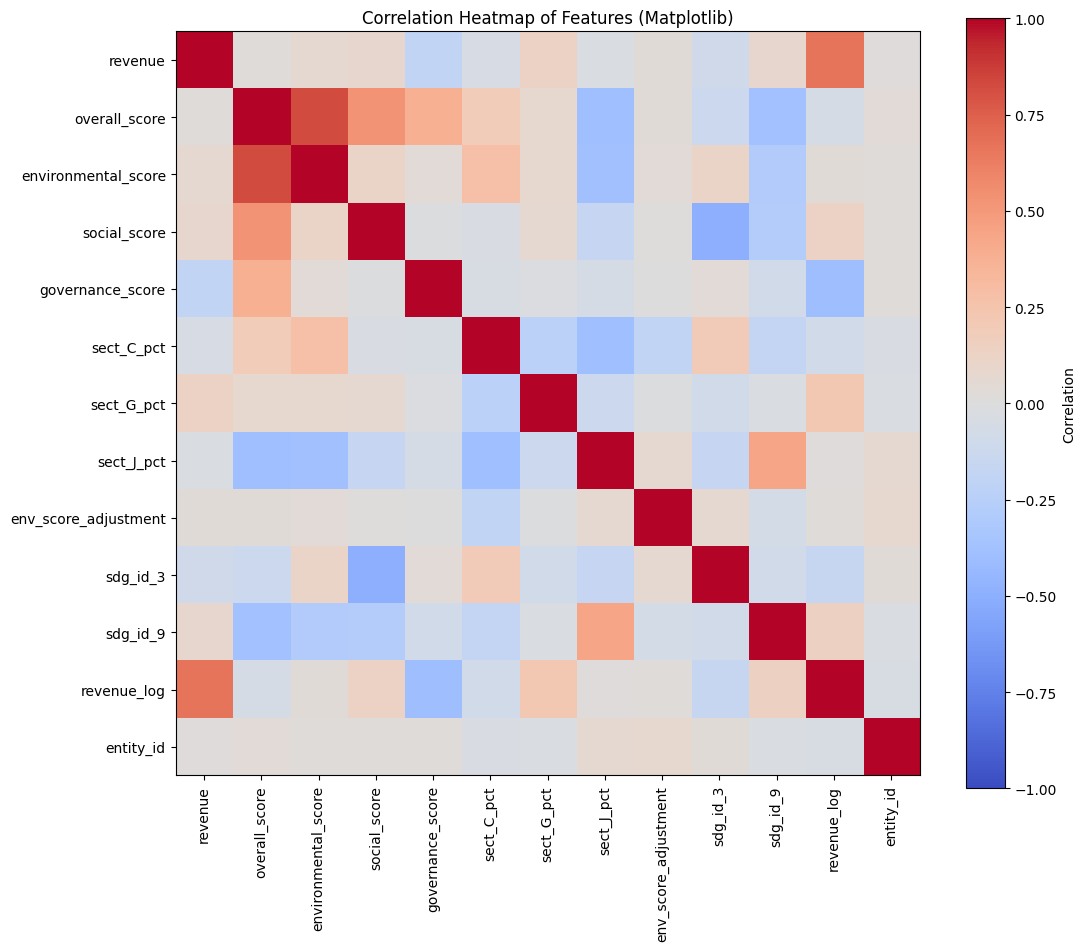

In [590]:
numeric_cols = final_train.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['target_scope_1', 'target_scope_2']]

corr_matrix = final_train[numeric_cols].corr().values

plt.figure(figsize=(12,10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title('Correlation Heatmap of Features (Matplotlib)')
plt.show()
